In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# All regression models
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import optuna

In [3]:
train_df= pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,683.0,25.0,0.50,0.38,0.38,0.75,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.383582,0.399556,30.546306,3923.90628
1,1,330.0,12.5,0.25,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.480073,0.448973,35.598217,5596.22636
2,2,155.0,12.5,0.25,0.25,0.38,0.38,77.4,46.8,64.7,55.8,27.0,45.8,1.0,0.10,0.594206,0.495898,41.059194,7406.90248
3,3,293.0,12.5,0.25,0.25,0.63,0.50,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.572046,0.486486,39.773462,7270.31832
4,4,343.0,12.5,0.25,0.25,0.75,0.75,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.532304,0.460322,37.209554,6132.99793


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15000 non-null  int64  
 1   Row#                  15000 non-null  float64
 2   clonesize             15000 non-null  float64
 3   honeybee              15000 non-null  float64
 4   bumbles               15000 non-null  float64
 5   andrena               15000 non-null  float64
 6   osmia                 15000 non-null  float64
 7   MaxOfUpperTRange      15000 non-null  float64
 8   MinOfUpperTRange      15000 non-null  float64
 9   AverageOfUpperTRange  15000 non-null  float64
 10  MaxOfLowerTRange      15000 non-null  float64
 11  MinOfLowerTRange      15000 non-null  float64
 12  AverageOfLowerTRange  15000 non-null  float64
 13  RainingDays           15000 non-null  float64
 14  AverageRainingDays    15000 non-null  float64
 15  fruitset           

In [6]:
train_df.isnull().sum()

id                      0
Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

<Axes: xlabel='yield', ylabel='Count'>

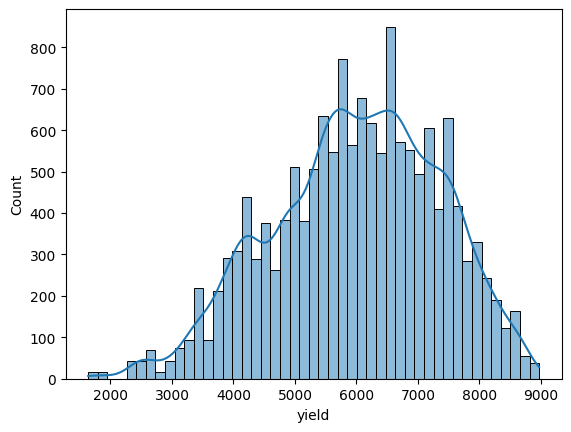

In [7]:
sns.histplot(train_df['yield'],kde='True')

No transformation is needed for the target variable as it is already normally distributed.

In [8]:
train_df.corr()['yield']

id                     -0.003041
Row#                   -0.013453
clonesize              -0.407381
honeybee               -0.118594
bumbles                 0.177254
andrena                 0.138811
osmia                   0.272579
MaxOfUpperTRange        0.014379
MinOfUpperTRange        0.014179
AverageOfUpperTRange    0.014262
MaxOfLowerTRange        0.014384
MinOfLowerTRange        0.014295
AverageOfLowerTRange    0.014435
RainingDays            -0.509233
AverageRainingDays     -0.520383
fruitset                0.952338
fruitmass               0.890149
seeds                   0.917960
yield                   1.000000
Name: yield, dtype: float64

<Axes: >

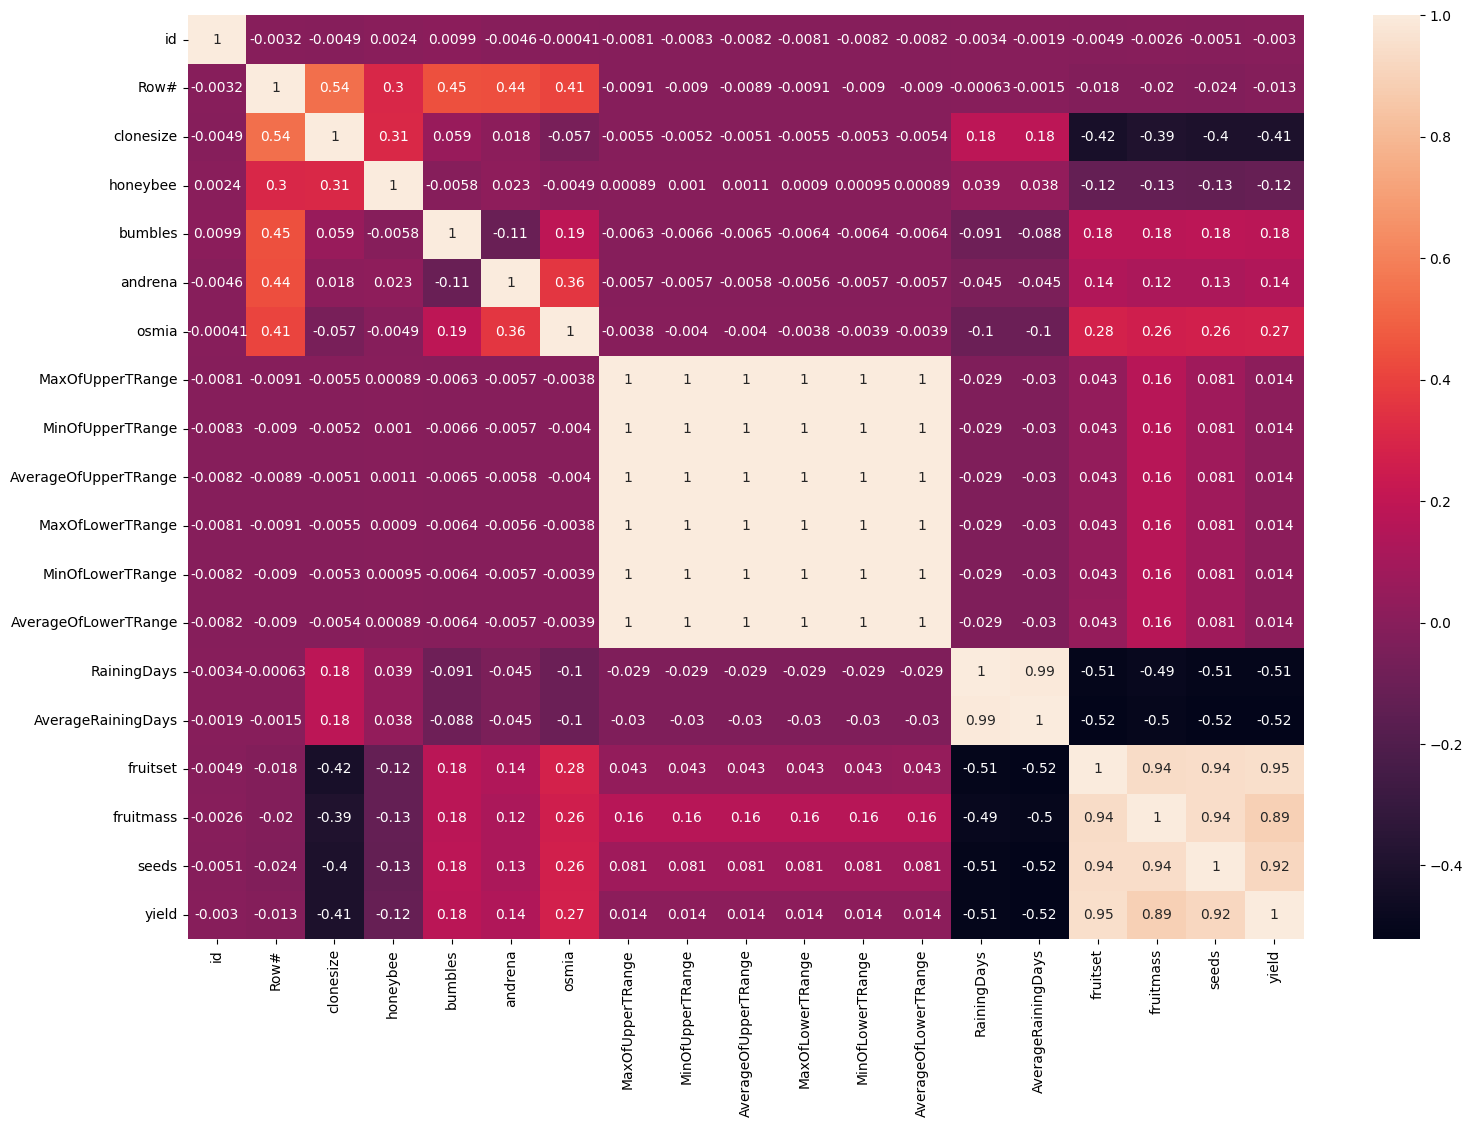

In [9]:
plt.figure(figsize=(18,12))
sns.heatmap(train_df.corr(), annot=True)

In [10]:
train_df.columns

Index(['id', 'Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [11]:
train_df.drop(['id','Row#','MaxOfUpperTRange', 'MinOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageRainingDays'], axis=1, inplace=True)
test_df.drop(['id','Row#','MaxOfUpperTRange', 'MinOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageRainingDays'], axis=1, inplace=True)

In [12]:
train_df.head()

,clonesize,honeybee,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,RainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.38,0.38,0.75,79.0,55.9,24.0,0.383582,0.399556,30.546306,3923.90628
1,12.5,0.25,0.25,0.75,0.63,71.9,50.8,34.0,0.480073,0.448973,35.598217,5596.22636
2,12.5,0.25,0.25,0.38,0.38,64.7,45.8,1.0,0.594206,0.495898,41.059194,7406.90248
3,12.5,0.25,0.25,0.63,0.50,79.0,55.9,16.0,0.572046,0.486486,39.773462,7270.31832
4,12.5,0.25,0.25,0.75,0.75,79.0,55.9,24.0,0.532304,0.460322,37.209554,6132.99793


In [13]:
X=train_df.iloc[:,:-1]
y=train_df['yield']


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
def evaluate_model(model_name,model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"MAE of {model_name} : {mae}")

# LINEAR MODELS

In [16]:
evaluate_model('Linear Regression', LinearRegression(), X_train_scaled, y_train, X_test_scaled, y_test)
evaluate_model('Ridge Regression', Ridge(), X_train_scaled, y_train, X_test_scaled, y_test)
evaluate_model('Lasso Regression', Lasso(), X_train_scaled, y_train, X_test_scaled, y_test)
evaluate_model('ElasticNet Regression', ElasticNet(), X_train_scaled, y_train, X_test_scaled, y_test)

MAE of Linear Regression : 267.9801653412538
MAE of Ridge Regression : 267.9832111673687
MAE of Lasso Regression : 267.8356104179874
MAE of ElasticNet Regression : 352.6921885325053


Linear models can be further optimized using hyperparameter tuning (GridSearchCV)

In [17]:
ridge_reg=Ridge()
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    ridge_reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)
evaluate_model('Ridge Regression after hyperparameter tuning', grid_search, X_train_scaled, y_train, X_test_scaled, y_test)

MAE of Ridge Regression after hyperparameter tuning : 267.9958862247498


In [18]:
lasso_reg=Lasso()
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    lasso_reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)
evaluate_model('Lasso Regression after hyperparameter tuning', grid_search, X_train_scaled, y_train, X_test_scaled, y_test)

MAE of Lasso Regression after hyperparameter tuning : 267.97300523188716


# SVR

In [19]:
evaluate_model('SVR', SVR(kernel='rbf'), X_train_scaled, y_train, X_test_scaled, y_test)

MAE of SVR : 620.7774168320645


# KNN

In [20]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)
    leaf_size = trial.suggest_int('leaf_size', 10, 100)
    algorithm = trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute'])

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        leaf_size=leaf_size,
        algorithm=algorithm
    )

    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
    mae=-score

    return mae

In [21]:
study_knn = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_knn.optimize(objective_knn, n_trials=50)

[I 2025-06-21 17:27:36,355] A new study created in memory with name: no-name-46a367be-660c-48ab-8481-59c4c2665503
[I 2025-06-21 17:27:37,096] Trial 0 finished with value: 310.2996644183263 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'p': 1, 'leaf_size': 30, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 310.2996644183263.
[I 2025-06-21 17:27:37,937] Trial 1 finished with value: 310.7070651197681 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'p': 1, 'leaf_size': 57, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 310.2996644183263.
[I 2025-06-21 17:27:38,576] Trial 2 finished with value: 332.9276697198674 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'p': 2, 'leaf_size': 74, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 310.2996644183263.
[I 2025-06-21 17:27:39,109] Trial 3 finished with value: 316.49351255444736 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 2, 'leaf_size': 23, 'algorithm': 'auto'}. Best is tr

In [22]:
best_model_KNN=KNeighborsRegressor(**study_knn.best_trial.params)
evaluate_model('KNN Regression', best_model_KNN, X_train_scaled, y_train, X_test_scaled, y_test)
print("Best hyperparameters for KNN:", study_knn.best_trial.params)

MAE of KNN Regression : 312.0102596753664
Best hyperparameters for KNN: {'n_neighbors': 20, 'weights': 'distance', 'p': 1, 'leaf_size': 50, 'algorithm': 'ball_tree'}


# Decision Tree Regressor

In [23]:
def objective_dtr(trial):
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = DecisionTreeRegressor(
        criterion='absolute_error',
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
    mae=-score

    return mae

In [24]:
study_dt = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_dt.optimize(objective_dtr, n_trials=50)

[I 2025-06-21 17:28:09,446] A new study created in memory with name: no-name-a7c15436-a52a-4c03-9719-c3360ad25067
[I 2025-06-21 17:28:11,060] Trial 0 finished with value: 277.88280337208334 and parameters: {'splitter': 'best', 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 0 with value: 277.88280337208334.
[I 2025-06-21 17:28:12,580] Trial 1 finished with value: 625.8735897979167 and parameters: {'splitter': 'random', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 277.88280337208334.
[I 2025-06-21 17:28:13,956] Trial 2 finished with value: 470.6883102091666 and parameters: {'splitter': 'random', 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 277.88280337208334.
[I 2025-06-21 17:28:15,289] Trial 3 finished with value: 390.9392159025 and parameters: {'splitter': 'random', 'max_depth': 12, 'min_

In [25]:
best_model_dtr=DecisionTreeRegressor(**study_dt.best_trial.params)
evaluate_model('Decision Tree Regression', best_model_dtr, X_train, y_train, X_test, y_test)
print("Best hyperparameters for Decision Tree:", study_dt.best_trial.params)

MAE of Decision Tree Regression : 244.52913422811633
Best hyperparameters for Decision Tree: {'splitter': 'best', 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}


Random Forest Regressor

In [26]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 20, step=5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestRegressor(**params, random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
    mae=-score

    return mae

In [27]:
study_rf = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_rf.optimize(objective_rf, n_trials=50)

[I 2025-06-21 17:30:46,742] A new study created in memory with name: no-name-41daf2a1-3907-4e1f-9ff8-90a6ecdae1e9
[I 2025-06-21 17:31:08,498] Trial 0 finished with value: 274.1963926269529 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 274.1963926269529.
[I 2025-06-21 17:31:21,012] Trial 1 finished with value: 247.91631962240044 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 247.91631962240044.
[I 2025-06-21 17:31:25,616] Trial 2 finished with value: 253.00658929433607 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 247.91631962240044.
[I 2025-06-21 17:31:52,464] Trial 3 finished with value: 245.99842479062463 and parameters: {'n_estimators': 900, 'max_depth': 10, 'min_samples_split

In [28]:
best_model_rf=RandomForestRegressor(**study_rf.best_trial.params)
evaluate_model('Random Forest Regression', best_model_rf, X_train, y_train, X_test, y_test)
print("Best hyperparameters for Random Forest:", study_rf.best_trial.params)

MAE of Random Forest Regression : 241.8561257001122
Best hyperparameters for Random Forest: {'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True}


Gradient Boosting Regressor

In [29]:
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    model = GradientBoostingRegressor(
        loss='absolute_error',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        subsample=subsample,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
    mae=-score

    return mae

In [30]:
study_gb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_gb.optimize(objective_gb, n_trials=50)

[I 2025-06-21 17:49:17,801] A new study created in memory with name: no-name-55d00457-7828-41dc-9d42-83a8e01754dd
[I 2025-06-21 17:49:20,715] Trial 0 finished with value: 291.15313528481573 and parameters: {'n_estimators': 97, 'learning_rate': 0.03629758503308137, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'log2', 'subsample': 0.8156554823402884}. Best is trial 0 with value: 291.15313528481573.
[I 2025-06-21 17:49:28,393] Trial 1 finished with value: 249.64576058080738 and parameters: {'n_estimators': 178, 'learning_rate': 0.08330057037319145, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 16, 'max_features': 'log2', 'subsample': 0.5485100317118627}. Best is trial 1 with value: 249.64576058080738.
[I 2025-06-21 17:49:40,323] Trial 2 finished with value: 253.4784753181287 and parameters: {'n_estimators': 133, 'learning_rate': 0.09482160410413293, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 'log2', '

In [31]:
best_model_gb=GradientBoostingRegressor(**study_gb.best_trial.params)
evaluate_model('Gradient Boosting Regression', best_model_gb, X_train, y_train, X_test, y_test)
print("Best hyperparameters for Gradient Boosting:", study_gb.best_trial.params)

MAE of Gradient Boosting Regression : 244.24982083999382
Best hyperparameters for Gradient Boosting: {'n_estimators': 280, 'learning_rate': 0.04912211830725148, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None, 'subsample': 0.8148701366894199}


Adaboost Regressor

In [32]:
def objective_ada(trial):
    base_max_depth = trial.suggest_int('base_max_depth', 1, 10)
    base_estimator = DecisionTreeRegressor(max_depth=base_max_depth)

    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    loss = trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])

    model = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss=loss,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
    mae=-score

    return mae

In [33]:
study_ada = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_ada.optimize(objective_ada, n_trials=50)

[I 2025-06-21 17:57:18,135] A new study created in memory with name: no-name-a551a9c5-c064-4515-92e5-4fa9e310cf0c
[I 2025-06-21 17:57:29,350] Trial 0 finished with value: 246.23063106727037 and parameters: {'base_max_depth': 10, 'n_estimators': 243, 'learning_rate': 0.028733803606179203, 'loss': 'linear'}. Best is trial 0 with value: 246.23063106727037.
[I 2025-06-21 17:57:31,962] Trial 1 finished with value: 250.74119394815207 and parameters: {'base_max_depth': 5, 'n_estimators': 96, 'learning_rate': 0.012262922511183315, 'loss': 'exponential'}. Best is trial 0 with value: 246.23063106727037.
[I 2025-06-21 17:57:34,356] Trial 2 finished with value: 265.5701157830814 and parameters: {'base_max_depth': 4, 'n_estimators': 107, 'learning_rate': 0.04187482206246321, 'loss': 'linear'}. Best is trial 0 with value: 246.23063106727037.
[I 2025-06-21 17:57:38,400] Trial 3 finished with value: 297.603491261401 and parameters: {'base_max_depth': 5, 'n_estimators': 171, 'learning_rate': 0.09910141

In [34]:
print(study_ada.best_trial.params)

{'base_max_depth': 10, 'n_estimators': 64, 'learning_rate': 0.011568391174549959, 'loss': 'exponential'}


In [55]:
best_model_ada=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                                 n_estimators=64,
                                 learning_rate=0.011568391174549959,
                                 loss='exponential',
                                 random_state=42
                                 )
evaluate_model('Adaboost Regression', best_model_ada, X_train, y_train, X_test, y_test)

MAE of Adaboost Regression : 237.91879908378795


XGBoost

In [36]:
def objective_xg(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    model = XGBRegressor(
        **params,
        tree_method = 'gpu_hist',
        device =  'cuda',
        random_state=42,
        verbosity=0
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
    mae=-score

    return mae

In [37]:
study_xg = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_xg.optimize(objective_xg, n_trials=50)
print("Best hyperparameters for XGBoost : ", study_xg.best_trial.params)

[I 2025-06-21 18:01:24,350] A new study created in memory with name: no-name-c4dabb8e-7724-4b79-a645-0354dafe11db
[I 2025-06-21 18:01:29,427] Trial 0 finished with value: 253.05915322065107 and parameters: {'n_estimators': 310, 'max_depth': 3, 'learning_rate': 0.02855476389261405, 'subsample': 0.5277756118787593, 'colsample_bytree': 0.5347026344694961, 'gamma': 0.8690432434051587, 'reg_alpha': 0.8086606790753748, 'reg_lambda': 0.563563004369827, 'min_child_weight': 5}. Best is trial 0 with value: 253.05915322065107.
[I 2025-06-21 18:01:43,656] Trial 1 finished with value: 270.47430385647783 and parameters: {'n_estimators': 491, 'max_depth': 10, 'learning_rate': 0.058408688300045516, 'subsample': 0.5305817828884383, 'colsample_bytree': 0.5553502325590889, 'gamma': 0.7407315373369833, 'reg_alpha': 3.979995534149914, 'reg_lambda': 4.335111054215349, 'min_child_weight': 10}. Best is trial 0 with value: 253.05915322065107.
[I 2025-06-21 18:02:01,420] Trial 2 finished with value: 284.2991379

Best hyperparameters for XGBoost :  {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.04116542188748056, 'subsample': 0.5406499500257735, 'colsample_bytree': 0.9840895445722438, 'gamma': 0.2671337325473474, 'reg_alpha': 0.38347930748907816, 'reg_lambda': 0.5182901784294125, 'min_child_weight': 10}


In [42]:
best_model_xg=XGBRegressor(**study_xg.best_trial.params)
evaluate_model('XGBoost', best_model_xg, X_train, y_train, X_test, y_test)
print("Best hyperparameters for XGBoost : ", study_xg.best_trial.params)

MAE of XGBoost : 242.0698846551302
Best hyperparameters for XGBoost :  {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.04116542188748056, 'subsample': 0.5406499500257735, 'colsample_bytree': 0.9840895445722438, 'gamma': 0.2671337325473474, 'reg_alpha': 0.38347930748907816, 'reg_lambda': 0.5182901784294125, 'min_child_weight': 10}


LightGBM

In [39]:
def objective_light(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        }
    model = LGBMRegressor(
        **params,
        device='gpu',
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
    mae=-score

    return mae

In [40]:
study_light = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_light.optimize(objective_light, n_trials=50)

[I 2025-06-21 18:06:40,459] A new study created in memory with name: no-name-b36c929a-8113-4a8e-87ff-792d70e86eaa
[I 2025-06-21 18:07:16,474] Trial 0 finished with value: 261.71460816565195 and parameters: {'n_estimators': 393, 'learning_rate': 0.060372994553703846, 'max_depth': 15, 'num_leaves': 143, 'subsample': 0.9166638985040632, 'colsample_bytree': 0.9301857947266412, 'reg_alpha': 0.9211992786212353, 'reg_lambda': 4.022199820421}. Best is trial 0 with value: 261.71460816565195.
[I 2025-06-21 18:07:46,835] Trial 1 finished with value: 264.33499132190616 and parameters: {'n_estimators': 571, 'learning_rate': 0.07118247728307835, 'max_depth': 11, 'num_leaves': 107, 'subsample': 0.7665705394174172, 'colsample_bytree': 0.7255224746929593, 'reg_alpha': 2.058676046759426, 'reg_lambda': 1.0433503432104396}. Best is trial 0 with value: 261.71460816565195.
[I 2025-06-21 18:08:00,259] Trial 2 finished with value: 258.0466104886446 and parameters: {'n_estimators': 162, 'learning_rate': 0.0965

In [59]:
best_model_light=LGBMRegressor(**study_light.best_trial.params)
evaluate_model('LightGBM', best_model_light, X_train, y_train, X_test, y_test)
print("Best hyperparameters for LightGBM : ", study_light.best_trial.params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] Start training from score 5990.536135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

# Preparing submission file

In [56]:
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')
test.drop(['id','Row#','MaxOfUpperTRange', 'MinOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageRainingDays'], axis=1, inplace=True)
submission['yield'] = best_model_ada.predict(test)
submission.to_csv('submission_ada.csv', index=False)

Adaboost got 250.58570 on kaggle

# Ensemble

In [74]:
rf_pred= best_model_rf.predict(test)
xg_pred= best_model_xg.predict(test)
ada_pred= best_model_ada.predict(test)

final_pred1 = 0.3 * rf_pred + 0.2 * xg_pred + 0.5 * ada_pred
final_pred2 = 0.25 * rf_pred + 0.25 * xg_pred + 0.5 * ada_pred


In [ ]:
submission['yield'] = final_pred1
submission.to_csv('submission_avg.csv', index=False)

submission_avg.csv got a score of 250.49423

In [75]:
submission['yield'] = final_pred2
submission.to_csv('submission_avg2.csv', index=False)

submission_avg2.csv got a score of 250.38869 (BEST MODEL)

In [60]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[
        ('rf', best_model_rf),
        ('xgb', best_model_xg),
        ('ada', best_model_ada),
    ],
    final_estimator=LinearRegression()
)

In [61]:
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

In [62]:
print(f"MAE of Stacking Regressor: {mae}")

MAE of Stacking Regressor: 238.2977964555158


In [72]:
y_pred_sub=stack.predict(test)
submission['yield'] = y_pred_sub
submission.to_csv('submission_stack.csv', index=False)

submission_stack.csv got a score of 251.09397